## Counting extended simplices on some simplices of the full matrix.

In this notebook, we will try to count all simplices whose sink has a bidirectional connection to another neuron. We will compare results between ER graphs and an actual column graph. For computational reasons, 10000 simplices are taken at a single time and the results are compared.

The algorithm is as follows:
1. The bidirectional connection adjacency matrix (i.e. Bij = 1 iff Aij and Aji) is retrieved.
2. For each simplex in the buffer, the number of its sink's bidirectional connections outside the simplex is retrieved. 
3. Counts are summed to obtain the extended simplex count.

This way, bi-simplices (i.e. n-nodes motifs that contain two n-1 simplices with a bidirectional connection between their sinks) are counted twice. This was done for simplicity/computational reasons; since the ratio extended_simplices/simplices is more than 4 times higher in in the real column, even in the worst case scenario this overcounting does not explain the overexpression.

For computational reasons, only 10000 random simplices per dimension were taken in consideration. We have done:
1. Ten trials with different simplices on a single ER instance with same n_nodes and density of column.
2. Ten trials with ten different ER instance with same n_nodes and density of column.
3. Ten trials with different simplices on the same column.

The average of the ER instances is in both case 1 and 2 around 19000 extended simplices per 10000 simplices for all dimensions <4 (where this count made sense), while for the real column (case 3) it depends on the dimension, and it grows with it, with a minimum in dimension one of 82000 - 83000 extended simplices per 10000 simplices, getting to 130000 extended simplices per 10000 simplices in dim 5.

### Imports 

Core imports

In [1]:
import multiprocessing as mp
from robust_motifs.custom_mp import prepare_shared_memory
from robust_motifs.counting import get_dag2_signature, get_n_extended_simplices
from robust_motifs.data import import_connectivity_matrix, save_count_er_graph, load_sparse_matrix_from_pkl

File tools

In [2]:
from pathlib import Path
import pickle
import h5py

Drawing tools

In [3]:
from robust_motifs.plot import plot_matrices
from robust_motifs.utilities import get_pos
import matplotlib.pyplot as plt

Other tools

In [4]:
import scipy.sparse as sp
import numpy as np
from itertools import product
from time import time
import os
from tqdm import tqdm

In [5]:
pool = mp.Pool()

## Comparison with Erdos-Reyni graph, random simplices

### Creating ER graph

In [6]:
import_connectivity_matrix(dataframe = False, type = 'csr')

100%|██████████| 55/55 [00:12<00:00,  4.58it/s]


<31346x31346 sparse matrix of type '<class 'numpy.bool_'>'
	with 7648079 stored elements in Compressed Sparse Row format>

In [12]:
n_nodes = 31346
density = 7648079/31346/31346

In [13]:
density

0.007783736164455195

In [9]:
path = Path("data/extended_simplices/full/ER_" + str(n_nodes) + ".flag")
path.parent.mkdir(parents=True, exist_ok = True)
flag_path, pickle_path, count_path = save_count_er_graph(path, n_nodes, density)


100%|██████████| 31346/31346 [00:00<00:00, 3450416.05it/s]
7650424it [00:11, 673369.92it/s]


In [22]:
overall_results = {}

In [25]:
####### data import ########
file_path = flag_path
matrix_path = pickle_path
complex_path = count_path
complex_file = h5py.File(complex_path, 'r')
matrix = load_sparse_matrix_from_pkl(matrix_path)
bid_matrix = matrix.multiply(matrix.T)
arrays, links = prepare_shared_memory(matrix, str(n_nodes))
bid_arrays,  bid_links = prepare_shared_memory(bid_matrix, "bid")
for _ in range(10):
    result_dictionary = {} # this stores extended simplices counts.
    aux_dictionary = {} # this stores simplex count
    ######## iteration #####
    for dimension in tqdm(range(1, 7)):
        try:
            ####### step 1: building the random iterator ######
            random_selection = np.random.choice(complex_file["Cells_" + str(dimension)].shape[0],
                                                min(10000,complex_file["Cells_" + str(dimension)].shape[0]),
                                                replace = False)
            random_selection.sort()
            simplex_iterator = iter(complex_file["Cells_" + str(dimension)][random_selection])
            ###### step 2: getting number of bidirectional targets ######
             # fictitious product to satisfy imap reqs of a single arugment.
            mp_iterator = product(simplex_iterator, [arrays], [bid_arrays])
            results = pool.imap(get_n_extended_simplices, mp_iterator)
            ###### step 3: counting extended simplices ######
            for elem in results:
                result_dictionary[dimension] = result_dictionary.get(dimension, 0) + elem[0]
        except KeyError: # If there are no simplices in h5 file..
                result_dictionary[dimension] = 0
        try:
            aux_dictionary[dimension] = len(complex_file["Cells_" + str(dimension)])
        except KeyError: # If there are no simplices in h5 file...
            aux_dictionary[dimension] = 0
        overall_results[dimension] = overall_results.get(dimension, []) + [result_dictionary[dimension]]
    print("Extended simplices for 10000 simplices per dimension")
    print(result_dictionary)
    print("Total simplices per dimension")
    print(aux_dictionary)
    # free shared memory
for link in links:
    link.unlink()
for link in bid_links:
    link.unlink()

  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 18756, 2: 18663, 3: 19248, 4: 46, 5: 0, 6: 0}
Total simplices per dimension
{1: 7647790, 2: 14523875, 3: 215318, 4: 28, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 18869, 2: 19020, 3: 19057, 4: 46, 5: 0, 6: 0}
Total simplices per dimension
{1: 7647790, 2: 14523875, 3: 215318, 4: 28, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 18619, 2: 19074, 3: 18986, 4: 46, 5: 0, 6: 0}
Total simplices per dimension
{1: 7647790, 2: 14523875, 3: 215318, 4: 28, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 19016, 2: 19143, 3: 19051, 4: 46, 5: 0, 6: 0}
Total simplices per dimension
{1: 7647790, 2: 14523875, 3: 215318, 4: 28, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 19146, 2: 19076, 3: 18725, 4: 46, 5: 0, 6: 0}
Total simplices per dimension
{1: 7647790, 2: 14523875, 3: 215318, 4: 28, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 19010, 2: 18883, 3: 18894, 4: 46, 5: 0, 6: 0}
Total simplices per dimension
{1: 7647790, 2: 14523875, 3: 215318, 4: 28, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 19081, 2: 18719, 3: 18945, 4: 46, 5: 0, 6: 0}
Total simplices per dimension
{1: 7647790, 2: 14523875, 3: 215318, 4: 28, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 19093, 2: 18865, 3: 18655, 4: 46, 5: 0, 6: 0}
Total simplices per dimension
{1: 7647790, 2: 14523875, 3: 215318, 4: 28, 5: 0, 6: 0}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 19156, 2: 18732, 3: 18919, 4: 46, 5: 0, 6: 0}
Total simplices per dimension
{1: 7647790, 2: 14523875, 3: 215318, 4: 28, 5: 0, 6: 0}


100%|██████████| 6/6 [00:48<00:00,  8.02s/it]

Extended simplices for 10000 simplices per dimension
{1: 18768, 2: 18712, 3: 18743, 4: 46, 5: 0, 6: 0}
Total simplices per dimension
{1: 7647790, 2: 14523875, 3: 215318, 4: 28, 5: 0, 6: 0}


(15000.0, 20000.0)

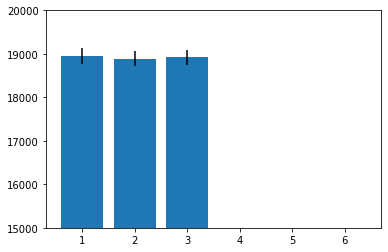

In [35]:
a = []
b = []
for elem in overall_results.values():
    a.append(np.mean(elem))
    b.append(np.std(elem))
plt.bar(range(1,7), a, yerr=b)
plt.ylim([15000, 20000])

#### NB

For each instance, we print two dictionaries: the first dictionary contains the number of extended simplices per dimension based on the 10000 simplices instance. The second dictonary contains the total number of simplices of the instance.

## Comparison with ER graph: random simplices, random instances. 

In [36]:
overall_results = {}

In [37]:
for _ in range(10):
    path = Path("data/extended_simplices/full/ER_" + str(n_nodes) + ".flag")
    path.parent.mkdir(parents=True, exist_ok = True)
    flag_path, pickle_path, count_path = save_count_er_graph(path, n_nodes, density)
    file_path = flag_path
    matrix_path = pickle_path
    complex_path = count_path
    complex_file = h5py.File(complex_path, 'r')
    matrix = load_sparse_matrix_from_pkl(matrix_path)
    bid_matrix = matrix.multiply(matrix.T)
    arrays, links = prepare_shared_memory(matrix, str(n_nodes))
    bid_arrays,  bid_links = prepare_shared_memory(bid_matrix, "bid")  
    result_dictionary = {} # this stores extended simplices counts.
    aux_dictionary = {} # this stores simplex count
    ######## iteration #####
    for dimension in tqdm(range(1, 7)):
        try:
            ####### step 1: compiling the dictionary ######
            random_selection = np.random.choice(complex_file["Cells_" + str(dimension)].shape[0],
                                                min(10000,complex_file["Cells_" + str(dimension)].shape[0]),
                                                replace = False)
            random_selection.sort()
            simplex_iterator = iter(complex_file["Cells_" + str(dimension)][random_selection])
            ###### step 2: getting bidirectional targets ######
             # fictitious product to satisfy imap reqs of a single arugment.
            mp_iterator = product(simplex_iterator, [arrays], [bid_arrays])
            results = pool.imap(get_n_extended_simplices, mp_iterator)
            ###### step 3: counting extended simplices ######
            for elem in results:
                result_dictionary[dimension] = result_dictionary.get(dimension, 0) + elem[0]
        except KeyError: # If there are no simplices in h5 file..
                result_dictionary[dimension] = 0
        try:
            aux_dictionary[dimension] = len(complex_file["Cells_" + str(dimension)])
        except KeyError: # If there are no simplices in h5 file...
            aux_dictionary[dimension] = 0
        overall_results[dimension] = overall_results.get(dimension, []) + [result_dictionary[dimension]]
    print("Extended simplices for 10000 simplices per dimension")
    print(result_dictionary)
    print("Total simplices per dimension")
    print(aux_dictionary)
    # free shared memory
    for link in links:
        link.unlink()
    for link in bid_links:
        link.unlink()

100%|██████████| 31346/31346 [00:00<00:00, 3348990.10it/s]
7645815it [00:12, 621055.49it/s]
100%|██████████| 6/6 [00:47<00:00,  7.97s/it]


Extended simplices for 10000 simplices per dimension
{1: 18929, 2: 19036, 3: 19090, 4: 29, 5: 0, 6: 0}
Total simplices per dimension
{1: 7645815, 2: 14513021, 3: 214416, 4: 14, 5: 0, 6: 0}


100%|██████████| 31346/31346 [00:00<00:00, 3097967.75it/s]
7647988it [00:12, 626774.85it/s]
100%|██████████| 6/6 [00:47<00:00,  7.91s/it]


Extended simplices for 10000 simplices per dimension
{1: 18849, 2: 18663, 3: 19060, 4: 58, 5: 0, 6: 0}
Total simplices per dimension
{1: 7647988, 2: 14518200, 3: 213562, 4: 30, 5: 0, 6: 0}


100%|██████████| 31346/31346 [00:00<00:00, 3355314.75it/s]
7650673it [00:12, 633019.06it/s]
100%|██████████| 6/6 [00:47<00:00,  7.98s/it]


Extended simplices for 10000 simplices per dimension
{1: 18803, 2: 18916, 3: 18909, 4: 44, 5: 0, 6: 0}
Total simplices per dimension
{1: 7650673, 2: 14537047, 3: 214129, 4: 28, 5: 0, 6: 0}


100%|██████████| 31346/31346 [00:00<00:00, 3399386.01it/s]
7647621it [00:12, 634822.33it/s]
100%|██████████| 6/6 [00:47<00:00,  7.91s/it]


Extended simplices for 10000 simplices per dimension
{1: 19094, 2: 18807, 3: 19166, 4: 60, 5: 0, 6: 0}
Total simplices per dimension
{1: 7647621, 2: 14520542, 3: 213811, 4: 26, 5: 0, 6: 0}


100%|██████████| 31346/31346 [00:00<00:00, 3417944.50it/s]
7647584it [00:12, 633609.18it/s]
100%|██████████| 6/6 [00:47<00:00,  7.99s/it]


Extended simplices for 10000 simplices per dimension
{1: 18930, 2: 19087, 3: 19030, 4: 49, 5: 0, 6: 0}
Total simplices per dimension
{1: 7647584, 2: 14518146, 3: 214374, 4: 27, 5: 0, 6: 0}


100%|██████████| 31346/31346 [00:00<00:00, 3330580.19it/s]
7650434it [00:12, 627717.59it/s]
100%|██████████| 6/6 [00:47<00:00,  7.92s/it]


Extended simplices for 10000 simplices per dimension
{1: 19067, 2: 19076, 3: 18846, 4: 32, 5: 0, 6: 0}
Total simplices per dimension
{1: 7650434, 2: 14532302, 3: 214764, 4: 22, 5: 0, 6: 0}


100%|██████████| 31346/31346 [00:00<00:00, 3170890.99it/s]
7647779it [00:12, 620687.92it/s]
100%|██████████| 6/6 [00:47<00:00,  7.91s/it]


Extended simplices for 10000 simplices per dimension
{1: 19270, 2: 19307, 3: 19006, 4: 44, 5: 0, 6: 0}
Total simplices per dimension
{1: 7647779, 2: 14525971, 3: 215046, 4: 23, 5: 0, 6: 0}


100%|██████████| 31346/31346 [00:00<00:00, 3381984.65it/s]
7649109it [00:12, 633755.87it/s]
100%|██████████| 6/6 [00:47<00:00,  7.92s/it]


Extended simplices for 10000 simplices per dimension
{1: 18636, 2: 18669, 3: 18962, 4: 43, 5: 0, 6: 0}
Total simplices per dimension
{1: 7649109, 2: 14538154, 3: 215328, 4: 19, 5: 0, 6: 0}


100%|██████████| 31346/31346 [00:00<00:00, 3255854.32it/s]
7642478it [00:12, 622026.57it/s]
100%|██████████| 6/6 [00:47<00:00,  7.95s/it]


Extended simplices for 10000 simplices per dimension
{1: 18871, 2: 19347, 3: 18904, 4: 22, 5: 0, 6: 0}
Total simplices per dimension
{1: 7642478, 2: 14493550, 3: 213750, 4: 14, 5: 0, 6: 0}


100%|██████████| 31346/31346 [00:00<00:00, 3413330.21it/s]
7655465it [00:11, 644170.17it/s]
100%|██████████| 6/6 [00:47<00:00,  7.90s/it]

Extended simplices for 10000 simplices per dimension
{1: 18995, 2: 19063, 3: 18982, 4: 30, 5: 0, 6: 0}
Total simplices per dimension
{1: 7655465, 2: 14564283, 3: 215641, 4: 20, 5: 0, 6: 0}


(15000.0, 20000.0)

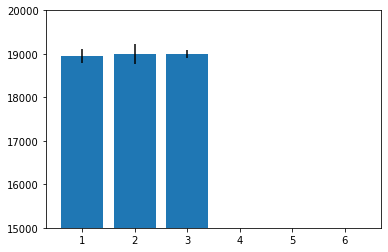

In [38]:
a = []
b = []
for elem in overall_results.values():
    a.append(np.mean(elem))
    b.append(np.std(elem))
plt.bar(range(1,7), a, yerr=b)
plt.ylim([15000, 20000])

## Comparison with ER graph: random simplices in column

In [6]:
overall_results = {}

In [7]:
complex_path = Path("data/tesi/test_instance/column-count.h5")
complex_file = h5py.File(complex_path, 'r')
matrix = import_connectivity_matrix(dataframe = False, type = 'csr')
bid_matrix = matrix.multiply(matrix.T)
arrays, links = prepare_shared_memory(matrix, "full")
bid_arrays, bid_links = prepare_shared_memory(bid_matrix, "bid")
for _ in range(10):
    result_dictionary = {}
    aux_dictionary = {}
######## iteration #####
    for dimension in tqdm(range(1, 7)):
        try:
            ####### step 1: compiling the dictionary ######
            random_selection = np.random.choice(complex_file["Cells_" + str(dimension)].shape[0],
                                                min(10000,complex_file["Cells_" + str(dimension)].shape[0]),
                                                replace = False)
            random_selection.sort()
            simplex_iterator = iter(complex_file["Cells_" + str(dimension)][random_selection])
            ###### step 2: getting bidirectional targets ######
             # fictitious product to satisfy imap reqs of a single arugment.
            mp_iterator = product(simplex_iterator, [arrays], [bid_arrays])
            results = pool.imap(get_n_extended_simplices, mp_iterator)
            ###### step 3: counting extended simplices ######
            for elem in results:
                result_dictionary[dimension] = result_dictionary.get(dimension, 0) + elem[0]
        except KeyError: # If there are no simplices in h5 file..
                result_dictionary[dimension] = 0
        try:
            aux_dictionary[dimension] = len(complex_file["Cells_" + str(dimension)])
        except KeyError: # If there are no simplices in h5 file...
            aux_dictionary[dimension] = 0
        
        overall_results[dimension] = overall_results.get(dimension, []) + [result_dictionary[dimension]]
    print("Extended simplices for 10000 simplices per dimension")
    print(result_dictionary)
    print("Total simplices per dimension")
    print(aux_dictionary)
    # free shared memory
for link in links:
    link.unlink()
for link in bid_links:
    link.unlink()

  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 83823, 2: 99633, 3: 112797, 4: 122141, 5: 131301, 6: 7208}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 83302, 2: 99903, 3: 112338, 4: 122715, 5: 130084, 6: 7208}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 83132, 2: 98937, 3: 113007, 4: 122390, 5: 131950, 6: 7208}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 82350, 2: 99784, 3: 111506, 4: 122016, 5: 131155, 6: 7208}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 82670, 2: 98656, 3: 111421, 4: 122583, 5: 130730, 6: 7208}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 83041, 2: 101454, 3: 112668, 4: 122663, 5: 130624, 6: 7208}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 81939, 2: 99573, 3: 112428, 4: 122317, 5: 130614, 6: 7208}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 82743, 2: 98819, 3: 112173, 4: 120814, 5: 130684, 6: 7208}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


  0%|          | 0/6 [00:00<?, ?it/s]

Extended simplices for 10000 simplices per dimension
{1: 83196, 2: 99803, 3: 112398, 4: 121952, 5: 130904, 6: 7208}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


100%|██████████| 6/6 [01:32<00:00, 15.46s/it]

Extended simplices for 10000 simplices per dimension
{1: 82081, 2: 100202, 3: 112554, 4: 122698, 5: 129972, 6: 7208}
Total simplices per dimension
{1: 7648079, 2: 73036616, 3: 59945205, 4: 6599529, 5: 133115, 6: 529}


(80000.0, 140000.0)

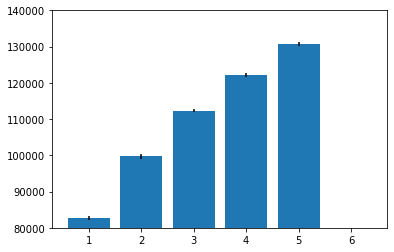

In [8]:
a = []
b = []
for elem in overall_results.values():
    a.append(np.mean(elem))
    b.append(np.std(elem))
plt.bar(range(1,7), a, yerr=b)
plt.ylim([80000, 140000])